### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2022 Semester 2

## Assignment 1

**Student Name:**    `Yu-Hsien, Chiang`

**Student ID:**     `1283355`

This iPython notebook is a template which you should use for your Assignment 3 submission. This file should be submitted at the **Assignment 3: Code** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a writren report explaining your results at the **Assignment 3: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

### 1. Load images and compute correspondences


In [12]:
import os
import numpy as np
from numpy import linalg as la
import cv2
import tqdm
from matplotlib import pyplot as plt

In [13]:
# Code from week 8 workshop

# Load image
rootPath= "./kusvod2"
imgA = cv2.imread(os.path.join(rootPath, "corrA.png"), cv2.IMREAD_COLOR)
imgB = cv2.imread(os.path.join(rootPath, "corrB.png"), cv2.IMREAD_COLOR)

# Initiate SIFT detector
sift = cv2.SIFT_create() # if cv2 version >= 4.4.0 
# sift = cv2.xfeatures2d.SIFT_create() # if cv2 version = 4.3.x

# Compute SIFT keypoints and descriptors
kpA, desA = sift.detectAndCompute(imgA, None)
kpB, desB = sift.detectAndCompute(imgB, None)

# FLANN parameters and initialize
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching descriptor using KNN algorithm
matches = flann.knnMatch(desA, desB, k=2)

# Apply ratio test
ptsA = []
ptsB = []

for i, (m,n) in enumerate(matches):
    if m.distance < 0.8 * n.distance: # was 0.7
        ptsA.append(kpA[m.queryIdx].pt)
        ptsB.append(kpB[m.trainIdx].pt)

ptsA = np.int32(ptsA)
ptsB = np.int32(ptsB)

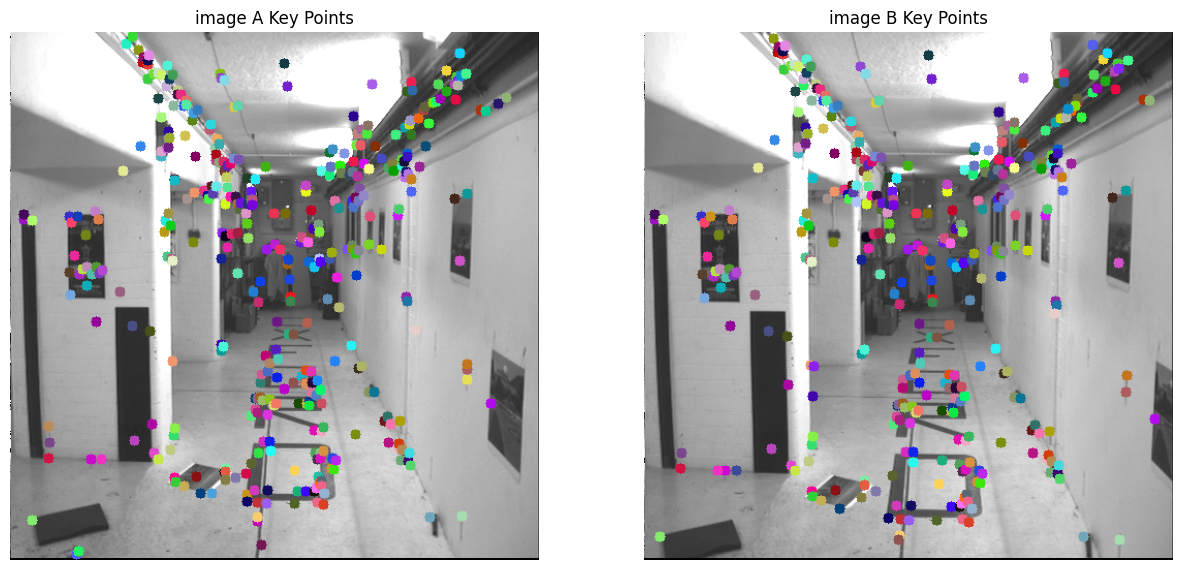

In [14]:
# Code from week 8 workshop

# Print image and key points
new1_imgA = imgA.copy()
new1_imgB = imgB.copy()

for ptA, ptB in zip(ptsA, ptsB):
    color = tuple(np.random.randint(0,255,3).tolist())
    new1_imgA = cv2.circle(new1_imgA, tuple(ptA), 5, color, -1)
    new1_imgB = cv2.circle(new1_imgB, tuple(ptB), 5, color, -1)

plt.subplots(figsize=(15, 15)) 

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(new1_imgA, cv2.COLOR_BGR2RGB))
plt.title('image A Key Points')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(new1_imgB, cv2.COLOR_BGR2RGB))
plt.title('image B Key Points')
plt.axis('off')

plt.show() 

### 2. Compute the Fundamental Matrix F using the 8 point algorithm

In [15]:
def randomSampleCorrPoint(ptsA, ptsB, num_point=8):
    """Radomly sample corespondences from the given data set

    Parameters
    ----------        
    ptsL : int numpy.ndarray, shape (n_correspondences, 2)
        An array of coordinates of correspondences from the left image. 
    ptsR : int numpy.ndarray, shape (n_correspondences, 2)
        An array of coordinates of correspondences from the right image. 
    num_point: int
        A number specifices the amount of ponts to sample from each array ptsL and ptsR. default = 8
    -------
    Return
    sample_ptsL : int numpy.ndarray, shape (num_point, 2)
        An array of coordinates of sample correspondences from the left image.  If num_point is greater than
        ptsL length, the original point set is return
    sample_ptsR : int numpy.ndarray, shape (num_point, 2)
        An array of coordinates of sample correspondences from the right image. If num_point is greater than
        ptsL length, the original point set is return
    """
    
    if num_point >= len(ptsA):
        return ptsA, ptsB
    else:
        rng = np.random.default_rng()
        ponit_index = rng.choice(np.arange(len(ptsA)), size=num_point, replace=False)
        sample_ptsA = ptsA[ponit_index,:]
        sample_ptsB = ptsB[ponit_index,:]
        return sample_ptsA, sample_ptsB


def conv2HomogeneousCor(ptsA, ptsB):
    """Convert points from cartesian coordinate to homogeneous coordinate

    Parameters
    ----------        
    ptsA : int numpy.ndarray, shape (n_correspondences, 2) or int numpy.ndarray, shape (2,)
        A coordinate or an array of coordinates of correspondences from image A.
    ptsB : int numpy.ndarray, shape (n_correspondences, 2) or int numpy.ndarray, shape (2,)
        A coordinate or an array of coordinates of correspondences from image B.
    -------
    Return
    ptsA_homo : float64 numpy.ndarray, shape (n_correspondences, 3) or int numpy.ndarray, shape (3,)
        A coordinate or an array of coordinates of correspondences from image A, in the form of homogeneous coordinate. 
    ptsB_homo : float64 numpy.ndarray, shape (n_correspondences, 3) or int numpy.ndarray, shape (3,)
        A coordinate or an array of coordinates of correspondences from image B, in the form of homogeneous coordinate. 
    """

    if ptsA.ndim == 1:
        ptsA_homo = np.pad(ptsA, (0,1), 'constant', constant_values=1.0)
        ptsB_homo = np.pad(ptsB, (0,1), 'constant', constant_values=1.0)
    else:
        ptsA_homo = np.pad(ptsA, [(0,0), (0,1)], 'constant', constant_values=1.0)
        ptsB_homo = np.pad(ptsB, [(0,0), (0,1)], 'constant', constant_values=1.0)
    
    return np.float64(ptsA_homo), np.float64(ptsB_homo)


def getNormalisationMat(pts):
    """Calculate the nomalisation matrix of the given coordinate points set

    Parameters
    ----------        
    pts : int numpy.ndarray, shape (n_correspondences, 2)
        An array of coordinate points.
    -------
    Return
    normalisationMat : float numpy.ndarray, shape (3, 3)
        The normalisation matrix of the given point set.
        This matrix translate and scale the points so that the mean coordinate is at (0,0) and average distance to (0,0) is sqrt(2)
    """

    pts = np.float64(pts)
    mean = np.array(np.sum(pts, axis=0) / len(pts), dtype=np.float64)
    scale = np.sum(la.norm(pts-mean, axis=1), axis=0) / (len(pts) * np.sqrt(2.0))
    normalisationMat = np.array([[1.0/scale, 0.0, -mean[0]/scale], [0.0, 1.0/scale, -mean[1]/scale], [0.0, 0.0, 1.0]], dtype=np.float64)
    return  normalisationMat

In [16]:
def getFundamentalMatrix(ptsA, ptsB, num_point=8):
    """Radomly sample corespondences from the given data set

    Parameters
    ----------        
    ptsA : int numpy.ndarray, shape (n_correspondences, 2)
        An array of coordinates of correspondences from image A.
    ptsB : int numpy.ndarray, shape (n_correspondences, 2)
        An array of coordinates of sample correspondences from the image B. 
    num_point : int, default = 8
        The number of correspondences from the entire point set being used to calculate the fundamental matrix
    -------
    Return
    F : float numpy.ndarray, shape (3, 3)
        Fundamental matrix based on the sample correspondences.
    """

    # Convert data type of points to float64
    ptsA = np.float64(ptsA)
    ptsB = np.float64(ptsB)

    # Sample num_point points
    sample_ptsA, sample_ptsB = randomSampleCorrPoint(ptsA, ptsB, num_point)
    
    # Get normalise matrix based on the sample points
    normalisationMat_A = getNormalisationMat(ptsA)
    normalisationMat_B = getNormalisationMat(ptsB)

    # Convert points to homogeneous coordinates
    sample_ptsA, sample_ptsB = conv2HomogeneousCor(sample_ptsA, sample_ptsB)

    # Normalise data points
    sample_ptsA_normal = np.float64([normalisationMat_A @ s_ptA for s_ptA in sample_ptsA])
    sample_ptsB_normal = np.float64([normalisationMat_B @ s_ptB for s_ptB in sample_ptsB])

    # Compute the design matrix
    design_matrix = np.array([(np.expand_dims(b, axis=1) @ np.expand_dims(a, axis=0)).flatten() for a, b in zip(sample_ptsA_normal, sample_ptsB_normal)])

    # SVD the design matrix
    U_des, s_des, VT_des = la.svd(design_matrix)

    # Find the vector V_i with the least cooresponding singular value
    f_vec = VT_des[-1,:]

    # Reform draft F from V_i
    f = np.float64(f_vec.reshape((3,3)))

    # SVD draft F
    U_f, s_f, VT_f = la.svd(f)

    # Set the least singular value of draft F to 0
    s_f[-1] = 0
    s_f_new = np.diag(s_f)

    # re-Construct F using the new S and draft U, draft V
    F_n = U_f @ s_f_new @ VT_f

    # De-normalise
    F = normalisationMat_B.T @ F_n @ normalisationMat_A
    F = F / F[-1,-1]

    return F

In [17]:
def getCorrespondencesEpilines(ptsA, ptsB, FundMat):
    """Compute the epipolar lines on image A and B based on the
       correspondences and the fundamental matrix

    Parameters
    ----------        
    ptsA : int numpy.ndarray, shape (n_correspondences, 3) or int numpy.ndarray, shape (3,)
        A coordinate or an array of coordinates of correspondences from image A.
    ptsB : int numpy.ndarray, shape (n_correspondences, 3) or int numpy.ndarray, shape (3,)
        A coordinate or an array of coordinates of correspondences from image B.
    F : float numpy.ndarray, shape (3, 3)
        Fundamental matrix.
    -------
    Return
    lines : float, numpy.ndarray, shape (num_points, 3)
        An array of the epipolar lines.  Each epipolar line is represented as an array of 
        three float number [a, b, c].  [a, b, c] are the coefficients of a line ax + by + c = 0.  
        Lines are normalised ao that sqrt(a^2 + b^2) = 1
    """
    
    # Convert data type to float64
    ptsA = np.float64(ptsA)
    ptsB = np.float64(ptsB)

    # If input is only a point
    if ptsA.ndim == 1:
        # Compute the lines
        linesA = np.array(ptsB @ FundMat, dtype=np.float64)
        linesB = np.array(FundMat @ ptsA.T, dtype=np.float64)
        
        # Normalise
        aA, bA, cA = linesA
        aB, bB, cB = linesB
        linesA = linesA / np.sqrt(aA*aA + bA*bA)
        linesB = linesB / np.sqrt(aB*aB + bB*bB)
    else:
        # Compute the lines
        linesA = np.array([pB @ FundMat for pB in ptsB], dtype=np.float64)
        linesB = np.array([FundMat @ pA.T for pA in ptsA], dtype=np.float64)
        
        # Normalise
        linesA = np.array([np.array([a/np.sqrt(a*a + b*b), b/np.sqrt(a*a + b*b), c/np.sqrt(a*a + b*b)], dtype=np.float64) for a, b, c in linesA], dtype=np.float64)
        linesB = np.array([np.array([a/np.sqrt(a*a + b*b), b/np.sqrt(a*a + b*b), c/np.sqrt(a*a + b*b)], dtype=np.float64) for a, b, c in linesB], dtype=np.float64)

    return linesA, linesB

In [18]:
def getFundamentalMatRANSAC(ptsA, ptsB, tol, num_sample=8, confidence=0.99):
    """Calculate the best fundamental Matrix for given correspondences using RANSAC

    Parameters
    ----------        
    ptsA : int numpy.ndarray, shape (n_correspondences, 2)
        An array of coordinates of correspondences from image A.
    ptsB : int numpy.ndarray, shape (n_correspondences, 2)
        An array of coordinates of correspondences from image B.
    tol : float
        the tolerance distance that allows a point to deviate from the epipolar line 
        and still be considered as inlier.  Inliers have distance <= tol from the epipolar line.
    num_point : int, default = 8
        The number of correspondences from the entire point set being used to calculate the fundamental matrix
    confidence : float, default = 0.99, 0 < confidence < 1
        The confidence of getting the fundamental matrix from subset of points that are all inliers
    -------
    Return
    best_F : float numpy.ndarray, shape (3, 3)
        The best fundamental matrix of the given correspondeces.
    best_inlier: int {0, 1} numpy.ndarray, shape (length_ptsL,)
        An array of 0 and 1, 1 means the coorespondence at the same index are inliers,
        0 means outliers.
    """

    best_inlier_num =  0
    best_inlier = np.zeros(len(ptsA))
    tol = np.float64(tol)

    # Iteration is calculated based on the confidence and the asumption that 50% correspondences are inliers 
    # and 50% correspondences are outliers.
    iterations = int(np.ceil(np.log10(1 - confidence) / np.log10(1 - np.float_power(0.5, num_sample))))

    for _ in tqdm.tqdm(range(iterations)):
        sample_ptsA, sample_ptsB = randomSampleCorrPoint(ptsA, ptsB, num_sample)
    
        F = getFundamentalMatrix(sample_ptsA, sample_ptsB)

        inlier = np.zeros(len(ptsA), dtype=np.float64)

        for i, (ptA, ptB) in enumerate(zip(ptsA, ptsB)):
            
            # Convert to homogeneous coordinate
            ptA_homo, ptB_homo = conv2HomogeneousCor(ptA, ptB)

            # Get the epipolar lines
            l_A, l_B = getCorrespondencesEpilines(ptA_homo, ptB_homo, F)
            l_A = np.float64(l_A)
            l_B = np.float64(l_B)
            
            # Calculate the error
            err_A = np.float64(abs(l_A @ ptA_homo))
            err_B = np.float64(abs(l_B @ ptB_homo))
            if (err_A <= tol and err_B <= tol):
                inlier[i] = 1
        
        if (np.sum(inlier) > best_inlier_num):
            best_inlier = inlier
            best_inlier_num = np.sum(inlier)
            best_F = F
    
    return best_F, best_inlier

In [19]:
# Analysis

tol = 1
# tol = 2

# Get Original F
F_og, mask_og = getFundamentalMatRANSAC(ptsA=ptsA, ptsB=ptsB, tol=tol, num_sample=8, confidence=0.99)


# Get Re-estimate Fundamental matrix using only inliers
inliersA_og = ptsA[mask_og.ravel() == 1]
inliersB_og = ptsB[mask_og.ravel() == 1]
F_ree, _ = getFundamentalMatRANSAC(ptsA=inliersA_og, ptsB=inliersB_og, tol=tol, num_sample=8, confidence=0.99)
# Get the inliers using F_ree
mask_ree = np.zeros(len(ptsA), dtype=np.float64)
for i, (ptA, ptB) in enumerate(zip(ptsA, ptsB)):
    ptA_homo, ptB_homo = conv2HomogeneousCor(ptA, ptB)
    l_A, l_B = getCorrespondencesEpilines(ptA_homo, ptB_homo, F_ree)
    l_A = np.float64(l_A)
    l_B = np.float64(l_B)
    err_A = np.float64(abs(l_A @ ptA_homo))
    err_B = np.float64(abs(l_B @ ptB_homo))
    if (err_A <= tol and err_B <= tol):
        mask_ree[i] = 1


# Get F using OpenCV library
F_cv, mask_cv = cv2.findFundamentalMat(ptsA, ptsB, method=cv2.RANSAC, ransacReprojThreshold=tol, confidence=0.99)


print("=================")
print(f"  Tolerance = {tol}  ")
print("=================")

print("| Original |")
print("Fundamental Matrix:")
print(f"{F_og}\n")
print(f"Number of inliers: {np.sum(mask_og)}\n")

print("| Re-estimated |")
print("Re-estimated Fundamental Matrix:")
print(f"{F_ree}\n")
print(f"Number of inliers: {np.sum(mask_ree)}\n")

print("| OpenCV |")
print("Fundamental Matrix:")
print(f"{F_cv}")
print(f"Number of inliers: {np.sum(mask_cv)}\n")

100%|██████████| 1177/1177 [02:50<00:00,  6.89it/s]

  Tolerance = 1  
| Original |
Fundamental Matrix:
[[ 1.54332224e-06  6.21238326e-04 -1.23672051e-01]
 [-6.20545397e-04  1.68633378e-07  1.44552570e-01]
 [ 1.23015706e-01 -1.49437077e-01  1.00000000e+00]]

Number of inliers: 373.0

| Re-estimated |
Re-estimated Fundamental Matrix:
[[ 2.60403782e-06  6.33985105e-04 -1.28875460e-01]
 [-6.34464470e-04  6.80753691e-08  1.45372170e-01]
 [ 1.28056071e-01 -1.49966159e-01  1.00000000e+00]]

Number of inliers: 368.0

| OpenCV |
Fundamental Matrix:
[[-1.50856513e-07  6.96118338e-04 -1.54479280e-01]
 [-6.93642684e-04 -1.75171776e-06  1.70410097e-01]
 [ 1.55024330e-01 -1.75694285e-01  1.00000000e+00]]
Number of inliers: 325



### 3. Randomly sample 10 correspondences and display images, corresponding points and epipolar lines

In [20]:
# Code referencing from week 8 workshop

def drawEpilines(imgA, imgB, lines, ptsA_homo, ptsB_homo):
    """Draw epipolar lines on img1 and key points on img1 and img2

    Parameters
    ----------        
    imgA : int numpy.ndarray, shape (height, width, channel)
        An array of image. 
    imgB : int numpy.ndarray, shape (n_correspondences, 2)
        An array of image. 
    lines : float, numpy.ndarray, shape (num_points, 3)
        A n array of the epipolar lines.  Each epipolar line is represented as an array of three float number [a, b, c].
        [a, b, c] are the coefficients of a line ax + by + c = 0
    ptsA_homo : int numpy.ndarray, shape (n_correspondences, 3)
        An array of coordinates of correspondences from the image A, in the form of homogeneous coordinate. 
    ptsB_homo : int numpy.ndarray, shape (n_correspondences, 3)
        An array of coordinates of correspondences from the image B, in the form of homogeneous coordinate. 
    -------
    Return
    annotate_imgA : int numpy.ndarray, shape (height, width, channel)
        An array of image, with epipolar lines and key points drawn on it  
    annotate_imgB : int numpy.ndarray, shape (height, width, channel)
        An array of image, with key points drawn on it
    """
    
    # Convert image to gray color in BGR representation
    annotate_imgA = cv2.cvtColor(cv2.cvtColor(imgA, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)
    annotate_imgB = cv2.cvtColor(cv2.cvtColor(imgB, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)
    row, col, cha = annotate_imgA.shape
    row -= 1        # index are in range of [0, height of image)
    col -= 1        # index are in range of [0, width of image)
    
    for r, ptA, ptB in zip(lines, ptsA_homo, ptsB_homo):
        # Generate color randomly
        color = tuple(np.random.randint(0, 255, 3).tolist())
        
        # Choosing valid points that lie on image boundaries
        a, b, c = r
        p0 = tuple(map(round, [0, -c / b]))
        p1 = tuple(map(round, [col, -(c + (a * col)) / b]))
        p2 = tuple(map(round, [-c / a, 0]))
        p3 = tuple(map(round, [-(c + (b * row)) / a, row]))
        p = [(x, y) for (x, y) in [p0, p1, p2, p3] if 0 <= x <= col and 0 <= y <= row]
        
        if (len(p) >= 2):
            annotate_imgA = cv2.line(annotate_imgA, p[0], p[1], color, 2)
        annotate_imgA = cv2.circle(annotate_imgA, tuple(ptA), 6, color, -1)
        annotate_imgB = cv2.circle(annotate_imgB, tuple(ptB), 6, color, -1)

    return annotate_imgA, annotate_imgB

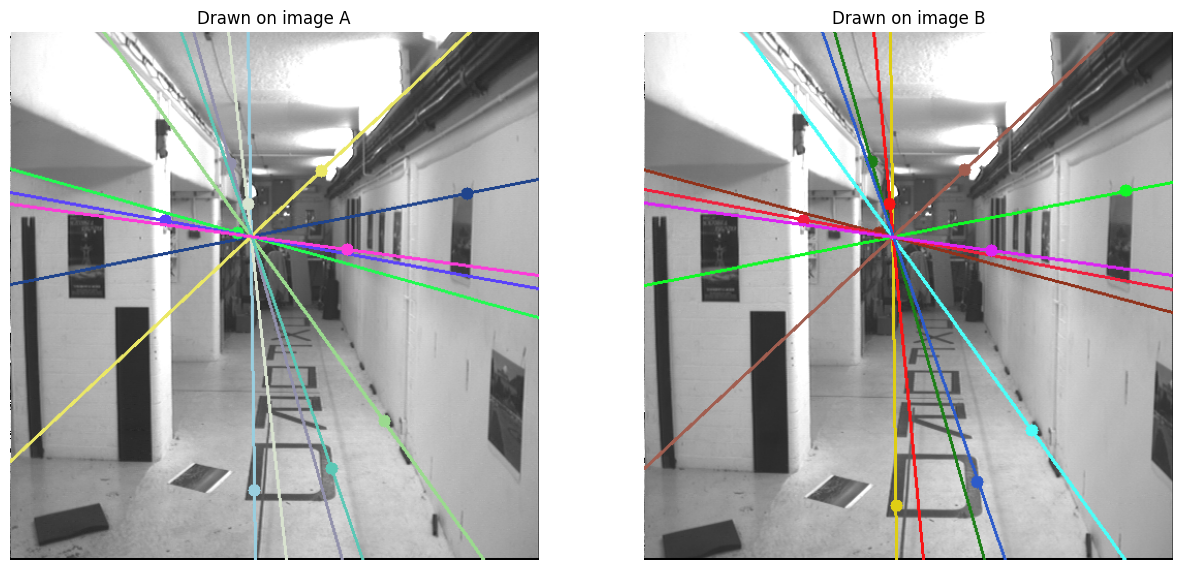

In [21]:
# Draw epipolar line using original F

new2_imgA = imgA.copy()
new2_imgB = imgB.copy()

# Get the inliers
inliersA_og = ptsA[mask_og.ravel() == 1]
inliersB_og = ptsB[mask_og.ravel() == 1]

# Get the sample of inliers
sample_inliersA_og, sample_inliersB_og = randomSampleCorrPoint(inliersA_og, inliersB_og, 10)

sample_inliersA_homo_og, sample_inliersB_homo_og = conv2HomogeneousCor(sample_inliersA_og, sample_inliersB_og)

linesA_og, linesB_og = getCorrespondencesEpilines(sample_inliersA_homo_og, sample_inliersB_homo_og, F_og)

imgA_annotate_og, imgB_2_og = drawEpilines(new2_imgA, new2_imgB, linesA_og, sample_inliersA_og, sample_inliersB_og)
imgB_annotate_og, imgA_2_og = drawEpilines(new2_imgB, new2_imgA, linesB_og, sample_inliersB_og, sample_inliersA_og)

# Display the results
plt.subplots(figsize=(15, 15)) 
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(imgA_annotate_og, cv2.COLOR_BGR2RGB))
plt.title('Drawn on image A')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(imgB_annotate_og, cv2.COLOR_BGR2RGB))  
plt.title('Drawn on image B')
plt.axis('off')

plt.show() 

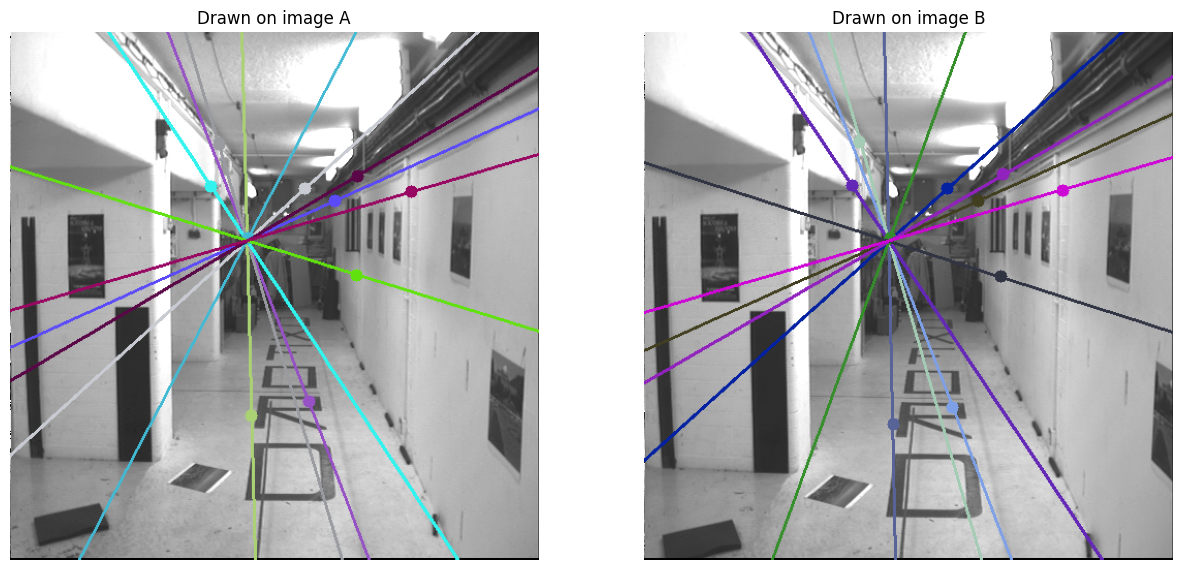

In [22]:
# Draw epipolar line using re-estimated F

new3_imgA = imgA.copy()
new3_imgB = imgB.copy()

# Get the inliers
inliersA_ree = ptsA[mask_ree.ravel() == 1]
inliersB_ree = ptsB[mask_ree.ravel() == 1]

# Get the sample of inliers
sample_inliersA_ree, sample_inliersB_ree = randomSampleCorrPoint(inliersA_ree, inliersB_ree, 10)

sample_inliersA_homo_ree, sample_inliersB_homo_ree = conv2HomogeneousCor(sample_inliersA_ree, sample_inliersB_ree)

linesA_ree, linesB_ree = getCorrespondencesEpilines(sample_inliersA_homo_ree, sample_inliersB_homo_ree, F_ree)

imgA_annotate_ree, imgB_2_ree = drawEpilines(new3_imgA, new3_imgB, linesA_ree, sample_inliersA_ree, sample_inliersB_ree)
imgB_annotate_ree, imgA_2_ree = drawEpilines(new3_imgB, new3_imgA, linesB_ree, sample_inliersB_ree, sample_inliersA_ree)


# Display the results
plt.subplots(figsize=(15, 15)) 
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(imgA_annotate_ree, cv2.COLOR_BGR2RGB))
plt.title('Drawn on image A')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(imgB_annotate_ree, cv2.COLOR_BGR2RGB))  
plt.title('Drawn on image B')
plt.axis('off')

plt.show()